# Anamoly Detection using AutoEncoder

This code is taken form medium post: https://towardsdatascience.com/a-keras-based-autoencoder-for-anomaly-detection-in-sequences-75337eaed0e5

In [1]:
import random
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 12, 6
sns.set(style='whitegrid', palette='muted', font_scale=1.5)


### Generate Sequence Data

In [3]:
first_letters =  'ABCDEF'
second_numbers = '120'
last_letters = 'QWOPZXML'

# returns a string of the following format: [4 letters A-F][1 digit 0-2][3 letters QWOPZXML]
def get_random_string():
    str1 = ''.join(random.choice(first_letters) for i in range(4))
    str2 = random.choice(second_numbers)
    str3 = ''.join(random.choice(last_letters) for i in range(3))
    return str1+str2+str3
    
print(get_random_string())

EBBC2PZL


In [4]:
# get 25,000 sequences of this format
random_sequences = [get_random_string() for i in range(25000)]
random_sequences[1:5]

['EEDC2XML', 'FBFE1PLW', 'EFBF1ZMO', 'EEBA1LPM']

In [5]:
#Build the char index that we will use to encode seqs to numbers
char_index = '0abcdefghijklmnopqrstuvwxyz'
char_index +='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
char_index += '123456789'
char_index += '().,-/+=&$?@#!*:;_[]|%⸏{}\"\'' + ' ' +'\\'

char_to_int = dict((c, i) for i, c in enumerate(char_index))
int_to_char = dict((i, c) for i, c in enumerate(char_index))

In [6]:
from keras.preprocessing.sequence import pad_sequences
#function that convert a char seqs to numbers seqs 
#(it does a little more but lets leave it for now)
def encode_sequence_list(seqs, feat_n=0):
    encoded_seqs = []
    for seq in seqs:
        encoded_seq = [char_to_int[c] for c in seq]
        encoded_seqs.append(encoded_seq)
    if(feat_n > 0):
        encoded_seqs.append(np.zeros(feat_n))
    return pad_sequences(encoded_seqs, padding='post')

def decode_sequence_list(seqs):
    decoded_seqs = []
    for seq in seqs:
        decoded_seq = [int_to_char[i] for i in seq]
        decoded_seqs.append(decoded_seq)
    return decoded_seqs


Using TensorFlow backend.


#### Adding anamoly to the sequence

In [7]:
# add some anomalies to our list
random_sequences.extend(['XYDC2DCA', 'TXSX1ABC','RNIU4XRE','AABDXUEI','SDRAC5RF'])
#save this to a dataframe
seqs_ds = pd.DataFrame(random_sequences)
# encode each string seq to an integer array [[1],[5],[67]], [[45],[76],[7]
encoded_seqs = encode_sequence_list(random_sequences)
# mix everything up
np.random.shuffle(encoded_seqs)
decoded_seqs = decode_sequence_list(encoded_seqs)
seqs_ds.head()

,0
0,DDAE1WQX
1,EEDC2XML
2,FBFE1PLW
3,EFBF1ZMO
4,EEBA1LPM


In [8]:
print(decoded_seqs[10])
print(encoded_seqs[10])

['E', 'A', 'E', 'B', '1', 'W', 'P', 'Q']
[31 27 31 28 53 49 42 43]


In [9]:
encoded_seqs.shape

(25005, 8)

### Prepare the Data and Build an Autoencoder

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_seqs = scaler.fit_transform(encoded_seqs)
X_train = scaled_seqs[:20000]
X_test = scaled_seqs[20000:]

In [23]:
X_train.shape

(20000, 8)

In [11]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = X_train.shape[1] #features
encoding_dim = 8
hidden_dim = int(encoding_dim / 2)

nb_epoch = 30
batch_size = 128
learning_rate = 0.1

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)



### Fit the Model

In [12]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mae'])

checkpointer = ModelCheckpoint(filepath="model_seqs2.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer]).history

Train on 20000 samples, validate on 5005 samples
Epoch 1/30
20000/20000 [==============================] - 0s 11us/step - loss: 0.1503 - mae: 0.2484 - val_loss: 0.0624 - val_mae: 0.1436
Epoch 2/30
20000/20000 [==============================] - 0s 6us/step - loss: 0.0549 - mae: 0.1421 - val_loss: 0.0490 - val_mae: 0.1387
Epoch 3/30
20000/20000 [==============================] - 0s 7us/step - loss: 0.0454 - mae: 0.1360 - val_loss: 0.0410 - val_mae: 0.1308
Epoch 4/30
20000/20000 [==============================] - 0s 7us/step - loss: 0.0373 - mae: 0.1256 - val_loss: 0.0331 - val_mae: 0.1182
Epoch 5/30
20000/20000 [==============================] - 0s 7us/step - loss: 0.0299 - mae: 0.1112 - val_loss: 0.0269 - val_mae: 0.1042
Epoch 6/30
20000/20000 [==============================] - 0s 7us/step - loss: 0.0250 - mae: 0.1000 - val_loss: 0.0234 - val_mae: 0.0972
Epoch 7/30
20000/20000 [==============================] - 0s 7us/step - loss: 0.0221 - mae: 0.0954 - val_loss: 0.0209 - val_mae: 0.094

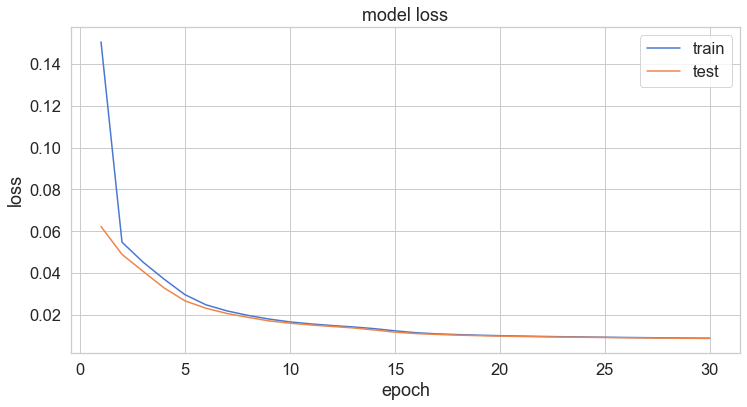

In [13]:
plt.plot(np.arange(1, 31), history['loss'])
plt.plot(np.arange(1, 31), history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [14]:
autoencoder = load_model('model_seqs2.h5')
print(f'Min Loss:{np.min(history["loss"])}')

Min Loss:0.009119325986504554


### Calculate the Error Term

In [15]:
#get the MSE error term
predictions = autoencoder.predict(scaled_seqs)
mse = np.mean(np.power(scaled_seqs - predictions, 2), axis=1)
print('MSE:', np.quantile(mse, 0.9999)) # => the 9999% quatile - only 0.0001% have error score higher than that


MSE: 0.163891400902213


### Lets return to the seqs_ds data set that holds all the sequences

In [16]:
#encode all the data
encoded_seqs = encode_sequence_list(seqs_ds.iloc[:,0])
#scale it
scaled_data = MinMaxScaler().fit_transform(encoded_seqs)
#predict it
predicted = autoencoder.predict(scaled_data)
#get the error term
mse = np.mean(np.power(scaled_data - predicted, 2), axis=1)
#now add them to our data frame
seqs_ds['MSE'] = mse

In [17]:
display(seqs_ds)

,0,MSE
0,DDAE1WQX,0.008053
1,EEDC2XML,0.002146
2,FBFE1PLW,0.016490
3,EFBF1ZMO,0.004218
4,EEBA1LPM,0.001938
...,...,...
25000,XYDC2DCA,0.232744
25001,TXSX1ABC,0.354355
25002,RNIU4XRE,0.162242
25003,AABDXUEI,0.012312


### Consider anamoly which lies beyond 0.9999 percentile of data

In [18]:
mse_threshold = np.quantile(seqs_ds['MSE'], 0.9999)
print(f'MSE 0.9999 threshhold:{mse_threshold}')

MSE 0.9999 threshhold:0.16389140627938745


In [19]:
seqs_ds['MSE_Outlier'] = 0
seqs_ds.loc[seqs_ds['MSE'] > mse_threshold, 'MSE_Outlier'] = 1

In [20]:
random_sequences[25000:]

['XYDC2DCA', 'TXSX1ABC', 'RNIU4XRE', 'AABDXUEI', 'SDRAC5RF']

In [21]:
print(f"Num of MSE outlier:{seqs_ds['MSE_Outlier'].sum()}")

seqs_ds.iloc[25000:]

Num of MSE outlier:3


,0,MSE,MSE_Outlier
25000,XYDC2DCA,0.232744,1
25001,TXSX1ABC,0.354355,1
25002,RNIU4XRE,0.162242,0
25003,AABDXUEI,0.012312,0
25004,SDRAC5RF,0.165544,1


In [22]:
seqs_ds[seqs_ds.MSE_Outlier == 1]

,0,MSE,MSE_Outlier
25000,XYDC2DCA,0.232744,1
25001,TXSX1ABC,0.354355,1
25004,SDRAC5RF,0.165544,1
